In [ ]:
!pip install concrete-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.5/202.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.6/671.6 kB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from concrete.ml.sklearn import LogisticRegression

# Lets create a synthetic data-set
x, y = make_classification(n_samples=100, class_sep=2, n_features=30, random_state=42)

# Split the data-set into a train and test set
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Now we train in the clear and quantize the weights
model = LogisticRegression(n_bits=8)
model.fit(X_train, y_train)

# We can simulate the predictions in the clear
y_pred_clear = model.predict(X_test)

# We then compile on a representative set
model.compile(X_train)

# Finally we run the inference on encrypted inputs !
y_pred_fhe = model.predict(X_test, fhe="execute")

print("In clear  :", y_pred_clear)
print("In FHE    :", y_pred_fhe)
print(f"Similarity: {int((y_pred_fhe == y_pred_clear).mean()*100)}%")


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In clear  : [0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0]
In FHE    : [0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0]
Similarity: 100%


In [ ]:
# Predict probability for a single example
y_proba_fhe = model.predict_proba(X_test[[0]], fhe="execute")

# Quantize an original float input
q_input = model.quantize_input(X_test[[0]])

# Encrypt the input
q_input_enc = model.fhe_circuit.encrypt(q_input)

# Execute the linear product in FHE
q_y_enc = model.fhe_circuit.run(q_input_enc)

# Decrypt the result (integer)
q_y = model.fhe_circuit.decrypt(q_y_enc)

# De-quantize and post-process the result
y0 = model.post_processing(model.dequantize_output(q_y))

print("Probability with `predict_proba`: ", y_proba_fhe)
print("Probability with encrypt/run/decrypt calls: ", y0)

Probability with `predict_proba`:  [[0.99621148 0.00378852]]
Probability with encrypt/run/decrypt calls:  [[0.99621148 0.00378852]]


In [ ]:
import shutil
from pathlib import Path
from time import time
from typing import Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm

from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier

In [ ]:
!pip install tenseal
import torch
import tenseal as ts
import pandas as pd
import random
from time import time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 14.7 MB/s eta 0:00:00


In [ ]:
data = pd.read_csv("creditcard.csv")
data = data.dropna()
data.set_axis([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31], axis='columns', inplace=True)
data.head()

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from concrete.ml.sklearn import LogisticRegression

x = data.drop(31, axis=1)
y = data[31]

X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.3,stratify=y, random_state=42)

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from concrete.ml.sklearn import LogisticRegression

from sklearn.model_selection import StratifiedKFold

x = data.drop(31, axis=1)
y = data[31]

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []
#X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.3,stratify=y, random_state=42)n

In [ ]:
skf

StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

In [ ]:
def grid_search(grid_param: Dict, clf: Callable) -> GridSearchCV:
    """
    Perform a grid search to find the best hyper-parameters for a given classifier.

    Args:
        grid_param (Dict): The hyper-parameters to be tuned
        clf (Callable): The given classifier

    Returns:
        GridSearchCV: The fitted GridSearchCV object.

    """
    grid_search = GridSearchCV(
        clf,
        grid_param,
        cv=4,
        verbose=1,
        n_jobs=-1,
    ).fit(X_train, y_train)



    # The best model
    print(grid_search)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_:.2%}")

    return grid_search


def fhe_evaluation(
    grid_search: GridSearchCV, clf_class: Callable, grid_param: Dict, X_test: np.ndarray
) -> pd.DataFrame:
    """
    Mesuare the time inference in FHE for each possible combinaison.

    Args:
        grid_search (GridSearchCV): Grid search object used to find the best hyperparameters
        clf_class (Callable): The classifier model to be evaluated
        grid_param (Dict): The hyper-parameters associated to the givin classifier
        X_test (np.ndarray): One sample used to measure the time inference in FHE

    Returns:
        pd.DataFrame: All combinaison of hyper-parameters and their mean test scores, standard test
            scores, and time inference in FHE

    """
    # Save the grid search results as a DataFrame
    grid_results = pd.DataFrame(grid_search.cv_results_)
    grid_results.columns = grid_results.columns.str.replace("param_", "")
    # Pick up relevent columns
    grid_results = grid_results[list(grid_param.keys()) + ["mean_test_score", "std_test_score"]]
    # Sort the results by mean_test_score in descending order
    grid_results = grid_results.sort_values(by="mean_test_score", ascending=False)

    fhe_inference_time = []
    for _, param in tqdm(grid_results[list(grid_param.keys())].iterrows()):
        # Instanciation
        clf = clf_class(**dict(param))
        # Training
        clf.fit(X_train, y_train)
        fhe_circuit = clf.compile(X_train)
        # Key generation
        fhe_circuit.client.keygen(force=False)
        # Inference
        start_time = time()
        _ = clf.predict(X_test, fhe="execute")
        fhe_inference_time.append(time() - start_time)
    grid_results["fhe_inference_time"] = fhe_inference_time

    return grid_results

In [ ]:
grid_xgb_param = {
    "n_bits": [2, 3, 4, 5, 6, 7],
    "max_depth": [1, 2, 3],
    "n_estimators": [2, 3],
}

gr_xgb = grid_search(grid_xgb_param, ConcreteXGBClassifier())

Fitting 4 folds for each of 36 candidates, totalling 144 fits
GridSearchCV(cv=4, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3], 'n_bits': [2, 3, 4, 5, 6, 7],
                         'n_estimators': [2, 3]},
             verbose=1)
Best parameters: {'max_depth': 1, 'n_bits': 2, 'n_estimators': 2}
Best score: 99.93%


In [ ]:
from statistics import mean, stdev
from sklearn import preprocessing
# Feature Scaling for input features.
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)

for train_index, test_index in skf.split(x, y):
    X_train, X_test = x_scaled[train_index], x_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print(X_train)



In [ ]:
grid_xgb_param = {
    "n_bits": [2, 3, 4, 5, 6, 7],
    "max_depth": [1, 2, 3],
    "n_estimators": [2, 3],
}

for train_index, test_index in skf.split(x, y):
    X_train, X_test = x_scaled[train_index], x_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gr_xgb = grid_search(grid_xgb_param, ConcreteXGBClassifier())
    #lr.fit(x_train_fold, y_train_fold)
    #lst_accu_stratified.append(lr.score(x_test_fold, y_test_fold))

#gr_xgb = grid_search(grid_xgb_param, ConcreteXGBClassifier())

Fitting 4 folds for each of 36 candidates, totalling 144 fits
GridSearchCV(cv=4, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3], 'n_bits': [2, 3, 4, 5, 6, 7],
                         'n_estimators': [2, 3]},
             verbose=1)
Best parameters: {'max_depth': 1, 'n_bits': 2, 'n_estimators': 2}
Best score: nan%
Fitting 4 folds for each of 36 candidates, totalling 144 fits
GridSearchCV(cv=4, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3], 'n_bits': [2, 3, 4, 5, 6, 7],
                         'n_estimators': [2, 3]},
             verbose=1)
Best parameters: {'max_depth': 1, 'n_bits': 2, 'n_estimators': 2}
Best score: nan%
Fitting 4 folds for each of 36 candidates, totalling 144 fits
GridSearchCV(cv=4, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3], 'n_bits': [2, 3, 4, 5, 6, 7],
                         'n_estimators': [2, 3]},
             verbose=1)
Best parameters: {

In [ ]:
gr_xgb.get_params()

{'cv': 4,
 'error_score': nan,
 'estimator__base_score': None,
 'estimator__booster': None,
 'estimator__colsample_bylevel': None,
 'estimator__colsample_bynode': None,
 'estimator__colsample_bytree': None,
 'estimator__enable_categorical': False,
 'estimator__gamma': None,
 'estimator__gpu_id': None,
 'estimator__importance_type': None,
 'estimator__interaction_constraints': None,
 'estimator__learning_rate': 0.1,
 'estimator__max_delta_step': None,
 'estimator__max_depth': 3,
 'estimator__min_child_weight': None,
 'estimator__missing': nan,
 'estimator__monotone_constraints': None,
 'estimator__n_bits': 6,
 'estimator__n_estimators': 20,
 'estimator__n_jobs': None,
 'estimator__num_parallel_tree': None,
 'estimator__objective': 'binary:logistic',
 'estimator__predictor': None,
 'estimator__random_state': None,
 'estimator__reg_alpha': None,
 'estimator__reg_lambda': None,
 'estimator__scale_pos_weight': None,
 'estimator__subsample': None,
 'estimator__tree_method': None,
 'estimator

In [ ]:
gr_xgb.cv_results_

{'mean_fit_time': array([0.2428003 , 0.20978737, 0.19960982, 0.20634806, 0.20302576,
        0.20602632, 0.20222628, 0.20164412, 0.19758964, 0.20950735,
        0.19941425, 0.33635956, 0.41245627, 0.39060891, 0.32476878,
        0.39853406, 0.36206841, 0.32080942, 0.24258941, 0.21871948,
        0.25116158, 0.2211737 , 0.21958989, 0.21296483, 0.212717  ,
        0.20516527, 0.19925457, 0.20833772, 0.1980707 , 0.21051168,
        0.20688891, 0.2189045 , 0.20710373, 0.21327847, 0.21135724,
        0.19602674]),
 'std_fit_time': array([0.04571559, 0.00764749, 0.00248331, 0.00234984, 0.00815391,
        0.00728173, 0.01058067, 0.00184808, 0.00317521, 0.00790388,
        0.003129  , 0.04156466, 0.04050553, 0.05278265, 0.06641538,
        0.04448309, 0.03046044, 0.11000421, 0.05130262, 0.00303414,
        0.03761654, 0.01071215, 0.01137485, 0.00212046, 0.0096294 ,
        0.00197899, 0.00900971, 0.00691813, 0.00374983, 0.00940588,
        0.00403462, 0.00747324, 0.00310447, 0.00440088, 0.010

In [ ]:
gr_xgb.cv_results_

{'mean_fit_time': array([0.90572464, 0.93395704, 0.85197473, 0.87403882, 1.04517078,
        1.49863303, 1.10674286, 0.90182012, 0.88536346, 0.91085166,
        0.87196451, 1.01619351, 1.59148997, 1.23295075, 0.86153209,
        0.92426085, 1.15501195, 2.30666393, 2.66138905, 1.56636995,
        0.93178117, 0.98154449, 1.52849591, 1.50723827, 0.92807364,
        1.03051275, 0.91898757, 1.01411784, 1.41073161, 1.66275418,
        0.95093846, 1.03653944, 0.95428389, 1.05735445, 1.59620261,
        1.47395968]),
 'std_fit_time': array([0.05724193, 0.02020714, 0.01314322, 0.04092686, 0.1966999 ,
        0.03586364, 0.21544858, 0.00908972, 0.02350606, 0.01484533,
        0.0143868 , 0.11996713, 0.0434774 , 0.20509857, 0.01394732,
        0.01330954, 0.14477477, 0.60979871, 0.26947217, 0.14798685,
        0.02834995, 0.03264176, 0.18771753, 0.22890096, 0.02770921,
        0.05134451, 0.01114602, 0.04290004, 0.31423462, 0.28738607,
        0.02206338, 0.01657159, 0.0107555 , 0.03541139, 0.273

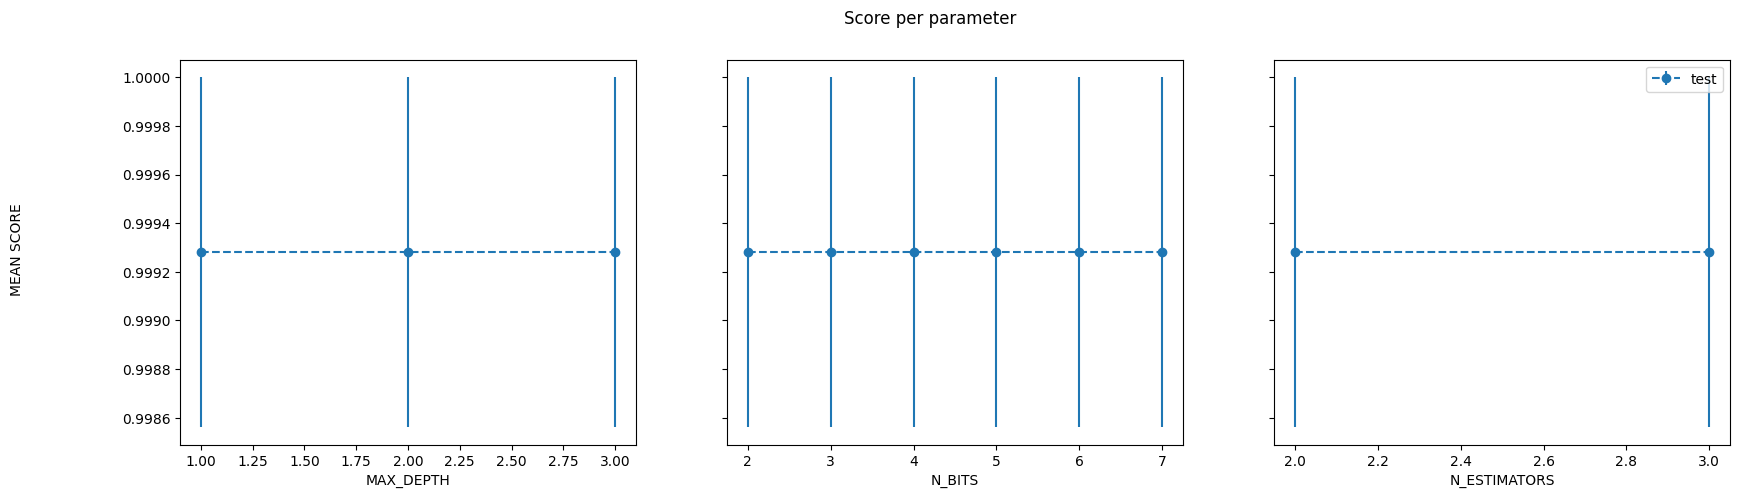

In [ ]:
def plot_search_results(grid):
    """
    Params:
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    #means_train = results['mean_fit_time']
    #stds_train = results['std_fit_time']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        #y_2 = np.array(means_train[best_index])
        #e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        #ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

plot_search_results(gr_xgb)

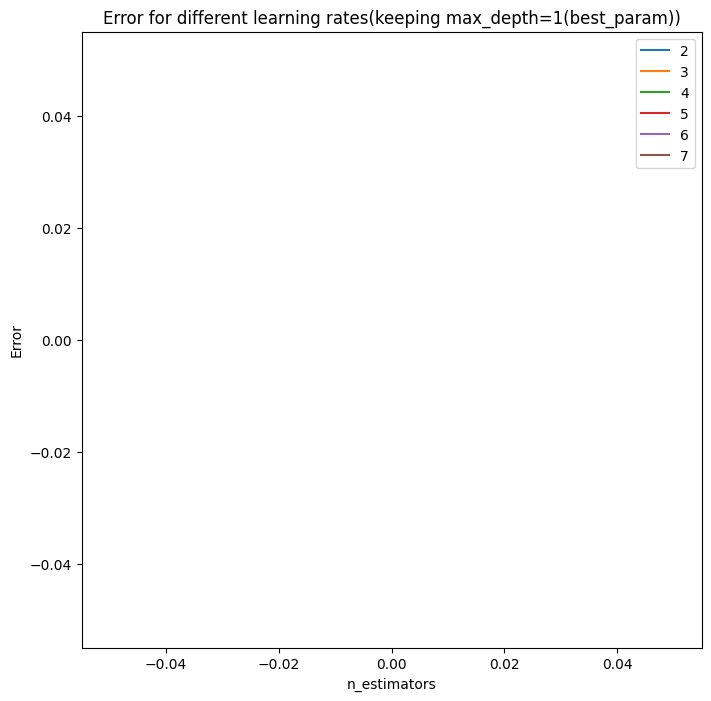

In [ ]:
y=[]
cvres = gr_xgb.cv_results_
best_md=gr_xgb.best_params_['max_depth']
la=grid_xgb_param['n_bits']
n_estimators=grid_xgb_param['n_estimators']

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    if params["max_depth"]==best_md:
        y.append(np.sqrt(-mean_score))


y=np.array(y).reshape(len(la),len(n_estimators))

%matplotlib inline
plt.figure(figsize=(8,8))
for y_arr, label in zip(y, la):
    plt.plot(n_estimators, y_arr, label=label)

plt.title('Error for different learning rates(keeping max_depth=%d(best_param))'%best_md)
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Error')
plt.show()

In [ ]:
grid_logit_param = {
    "C": [ 1.0],
    #"n_bits": [7, 10, 13, 14],
    "n_bits": [7],
    #"solver": ["sag", "saga"],
    "solver": ["sag"],
    "multi_class": ["auto"],
}

gs_logit = grid_search(grid_logit_param, ConcreteLogisticRegression())


Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters: {'C': 1.0, 'multi_class': 'auto', 'n_bits': 7, 'solver': 'sag'}
Best score: 99.82%


In [ ]:
import time

import pandas as pd
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForestClassifier
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Import models from scikit-learn and XGBoost
from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTreeClassifier
from xgboost import XGBClassifier as SklearnXGBoostClassifier

# Import models from Concrete ML
from concrete.ml.sklearn import DecisionTreeClassifier as ConcreteDecisionTreeClassifier
from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression
from concrete.ml.sklearn import RandomForestClassifier as ConcreteRandomForestClassifier
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBoostClassifier

CONCRETE_ML_MODELS = [
    ConcreteDecisionTreeClassifier,
    ConcreteLogisticRegression,
    ConcreteRandomForestClassifier,
    ConcreteXGBoostClassifier,
]

In [ ]:
def evaluate(
    model, x, y, test_size=0.33, show_circuit=False, predict_in_fhe=True, fhe_samples=None
):
    """Evaluate the given model using several metrics.

    The model is evaluated using the following metrics: accuracy, F1 score, precision, recall.
    For Concrete ML models, the inference's execution time is provided when done in FHE.

    Args:
        model: The initialized model to consider.
        x: The input data to consider.
        y: The target data to consider.
        test_size: The proportion to use for the test data. Default to 0.33.
        show_circuit: If the FHE circuit should be printed for Concrete ML models. Default to False.
        predict_in_fhe: If the inference should be executed in FHE for Concrete ML models. Else, it
            will only be simulated.
        fhe_sample: The number of samples to consider for evaluating the inference of Concrete ML
            models if predict_in_fhe is set to True. If None, the complete test set is used. Default
            to None.
    """
    evaluation_result = {}

    is_concrete_ml = model.__class__ in CONCRETE_ML_MODELS

    name = model.__class__.__name__ + (" (Concrete ML)" if is_concrete_ml else " (sklearn)")

    evaluation_result["name"] = name

    print(f"Evaluating model {name}")

    # Split the data into test and train sets. Stratify is used to make sure that the test set
    # contains some representative class distribution for targets
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, stratify=y, test_size=test_size, random_state=1
    )
    test_length = len(x_test)

    evaluation_result["Test samples"] = test_length

    evaluation_result["n_bits"] = model.n_bits if is_concrete_ml else None

    # Normalization pipeline
    model = Pipeline(
        [
            ("preprocessor", StandardScaler()),
            ("model", model),
        ]
    )

    # Train the model
    model.fit(x_train, y_train)

    # Run the prediction and store its execution time
    y_pred = model.predict(x_test)

    # Evaluate the model
    # For Concrete ML models, this will execute the (quantized) inference in the clear
    evaluation_result["Accuracy (clear)"] = accuracy_score(y_test, y_pred)
    evaluation_result["F1 (clear)"] = f1_score(y_test, y_pred, average="macro")
    evaluation_result["Precision (clear)"] = precision_score(y_test, y_pred, average="macro")
    evaluation_result["Recall (clear)"] = recall_score(y_test, y_pred, average="macro")

    # If the model is from Concrete ML
    if is_concrete_ml:

        print("Compile the model")

        # Compile the model using the training data
        circuit = model["model"].compile(x_train)  # pylint: disable=no-member

        # Print the FHE circuit if needed
        if show_circuit:
            print(circuit)

        # Retrieve the circuit's max bit-width
        evaluation_result["max bit-width"] = circuit.graph.maximum_integer_bit_width()

        print("Predict (simulated)")

        # Run the prediction in the clear using FHE simulation, store its execution time and
        # evaluate the accuracy score
        y_pred_simulate = model.predict(x_test, fhe="simulate")

        evaluation_result["Accuracy (simulated)"] = accuracy_score(y_test, y_pred_simulate)

        # Run the prediction in FHE, store its execution time and evaluate the accuracy score
        if predict_in_fhe:
            if fhe_samples is not None:
                x_test = x_test[0:fhe_samples]
                y_test = y_test[0:fhe_samples]
                test_length = fhe_samples

            evaluation_result["FHE samples"] = test_length

            print("Predict (FHE)")

            before_time = time.time()
            y_pred_fhe = model.predict(x_test, fhe="execute")
            evaluation_result["FHE execution time (second per sample)"] = (
                time.time() - before_time
            ) / test_length

            evaluation_result["Accuracy (FHE)"] = accuracy_score(y_test, y_pred_fhe)

    print("Done !\n")

    return evaluation_result

In [ ]:
results = []

# Define the test size proportion
test_size = 0.2

# For testing FHE execution locally, define the number of inference to run. If None, the complete
# test set is used
fhe_samples = None

# Logistic regression
results.append(evaluate(SklearnLogisticRegression(), x_basic, y, test_size=test_size))
#results.append(evaluate(ConcreteLogisticRegression(), x_basic, y, test_size=test_size))

# Define the initialization parameters for tree-based models
init_params_dt = {"max_depth": 10}
init_params_rf = {"max_depth": 7, "n_estimators": 5}
init_params_xgb = {"max_depth": 7, "n_estimators": 5}
init_params_cml = {"n_bits": 3}

# Determine the type of models to evaluate
use_dt = True
use_rf = True
use_xgb = True
predict_in_fhe = True

# Decision tree models
if use_dt:

    # Scikit-Learn model
    results.append(
        evaluate(
            SklearnDecisionTreeClassifier(**init_params_dt),
            x_basic,
            y,
            test_size=test_size,
        )
    )

    # Concrete ML model
    results.append(
        evaluate(
            ConcreteDecisionTreeClassifier(**init_params_dt, **init_params_cml),
            x_basic,
            y,
            test_size=test_size,
            predict_in_fhe=predict_in_fhe,
            fhe_samples=fhe_samples,
        )
    )

# Random Forest
if use_rf:

    # Scikit-Learn model
    results.append(
        evaluate(
            SklearnRandomForestClassifier(**init_params_rf),
            x_basic,
            y,
            test_size=test_size,
        )
    )

    # Concrete ML model
    results.append(
        evaluate(
            ConcreteRandomForestClassifier(**init_params_rf, **init_params_cml),
            x_basic,
            y,
            test_size=test_size,
            predict_in_fhe=predict_in_fhe,
            fhe_samples=fhe_samples,
        )
    )

# XGBoost
if use_xgb:

    # Scikit-Learn model
    results.append(
        evaluate(
            SklearnXGBoostClassifier(**init_params_xgb),
            x_basic,
            y,
            test_size=test_size,
        )
    )

    # Concrete ML model
    results.append(
        evaluate(
            ConcreteXGBoostClassifier(**init_params_xgb, **init_params_cml),
            x_basic,
            y,
            test_size=test_size,
            predict_in_fhe=predict_in_fhe,
            fhe_samples=fhe_samples,
        )
    )

Evaluating model LogisticRegression (sklearn)
Done !

Evaluating model DecisionTreeClassifier (sklearn)
Done !

Evaluating model DecisionTreeClassifier (Concrete ML)
Compile the model
Predict (simulated)
Predict (FHE)


In [ ]:

pd.set_option("display.precision", 3)

results_dataframe = pd.DataFrame(results)
results_dataframe.fillna("")